In [1]:
#from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

import tensorflow_probability as tfp

import cvxpy as cp

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [3]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [4]:
env = gym.make('CartPole-v0')
#env = wrappers.Monitor(env, 'video')
env.reset()

array([-0.02160965,  0.03382679,  0.02496426, -0.03225128])

In [5]:
env.action_space

Discrete(2)

In [6]:
S_DIM = 4
ACTIONS = 2

In [7]:
# states
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
disc_rewards = tf.placeholder(tf.float64, shape = (None,))

# costs obtained
disc_costs = tf.placeholder(tf.float64, shape = (None,))

def fc_layer(x, n, activation = tf.nn.sigmoid):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [8]:
# layers
with tf.name_scope('layers'):
    z = states # state is an input
    z = fc_layer(z, 10)
    z# = fc_layer(z, 10)
    #z = fc_layer(z, 10)
    z = fc_layer(z, ACTIONS, activation = None)
    output = z

In [9]:
# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

In [10]:
params = tf.trainable_variables()

Want to optimize the sum of rewards:
$$
J(\theta)=\mathbb{E}_{\pi(\theta)}\sum\limits_{t=0}^\infty r_t
$$

Take the gradient and use log-likelihood trick:
$$
\nabla J(\theta)=\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\nabla_\theta \log \pi(a_t|s_t)=\nabla_\theta\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Therefore the task is equivalent to minimizing a loss of
$$
\mathbb{E}_{\pi}\sum\limits_{t=0}^\infty r_t\log \pi(a_t|s_t)
$$

Which is estimated stochastically using episodes.

## Safe algo 1: <a href="https://arxiv.org/pdf/1705.10528.pdf">Constrained Policy Optimization</a>

Estimating $g=\nabla_\theta J_r(\pi)$ using policy gradients

Estimating $b=\nabla_\theta J_C(\pi)$ using policy gradients

Estimating $H=\mathbb{E}\frac{\partial^2}{\partial \theta^2}D_{KL}(\theta'|\theta)$

Constants: $\delta$ step size for trust region, $c=J_C-d$, where $d$ is the maximal per-episode value.

In [11]:
# learning rate for policy gradients
gamma_discount = 0.95

In [12]:
def discount(rewards):
    """ Discount and do cumulative sum """
    sum_so_far = 0.0
    rewards_so_far = []
    for r in rewards[::-1]:
        sum_so_far = sum_so_far * gamma_discount + r
        rewards_so_far.append(sum_so_far)
    return rewards_so_far[::-1]

In [13]:
np.allclose(discount([1,2,3]), [3 * gamma_discount ** 2 + 2 * gamma_discount + 1, 3 * gamma_discount + 2, 3])

True

In [14]:
def dz_dw_flatten(z, params):
    """ Calculate dz/dparams and flatten the result """
    return tf.concat([tf.reshape(x, shape = (-1,)) for x in tf.gradients(z, params)], axis = 0)

def iterate_flatten(tensor):
    """ Iterate over flattened items of a tensor """
    if type(tensor) == list:
        for t in tensor:
            for v in iterate_flatten(t):
                yield v
    elif len(tensor.shape) == 0:
        yield tensor
    else:
        for idx in range(tensor.shape[0]):
            for v in iterate_flatten(tensor[idx]):
                yield v
                
def tf_hessian(var, params):
    # gradients of the loss w.r.t. params
    grads = tf.gradients(var, params)
    grad_components = list(iterate_flatten(grads))
    hessian = [dz_dw_flatten(t, params) for t in tqdm(grad_components)]
    return hessian

In [15]:
# one-hot encoded actions
a_one_hot = tf.one_hot(actions, ACTIONS)

# taken logits
#logits_taken = tf.gather(logits, actions, axis = 1)
logits_taken = tf.boolean_mask(logits, a_one_hot)

# logarithm
log_logits = tf.log(logits_taken)

# calculated loss
loss_r = -tf.reduce_sum(tf.multiply(log_logits, disc_rewards))
loss_c = -tf.reduce_sum(tf.multiply(log_logits, disc_costs))

# KL(pi(a)||pi(a) fixed)
kl_div_var_fixed = tf.reduce_mean(tfp.distributions.kl_divergence(
    tf.distributions.Categorical(probs = logits),
    tf.distributions.Categorical(probs = tf.stop_gradient(logits))))
    #tf.distributions.Categorical(probs = logits))) #!!! not using this because want variable first parameter and fixed second

# policy gradient for reward
g = list(iterate_flatten(tf.gradients(-loss_r, params)))

# policy gradient for constraint
b = list(iterate_flatten(tf.gradients(-loss_c, params)))

# hessian of KL divergence (parameter H)
H = tf_hessian(kl_div_var_fixed, params)

# flattened parameters
theta = list(iterate_flatten(params))

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
100%|██████████| 72/72 [00:11<00:00,  5.03it/s]


In [16]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    p = sess.run(logits, feed_dict = {states: [observation]})[0]
    return np.random.choice(range(2), p = p)

In [17]:
observations = []

In [18]:
def cost(obs):
    """ Calculate scalar cost of one observation """
    assert isinstance(obs, np.ndarray) and obs.shape == (4,), "Input must be an np-array [x xdot phi phidot]"
    
    # parsing input
    x, x_dot, phi, phi_dot = obs
    
    X_MAX = 1.0
    X_DOT_MAX = 0.5
    PHI_MAX = 0.1
    PHI_DOT_MAX = 0.5
    
    if x < 0 or phi < 0:
        return 1
    
    #if np.any(np.abs([x, x_dot, phi, phi_dot]) > [X_MAX, X_DOT_MAX, PHI_MAX, PHI_DOT_MAX]):
    #    return 1
    
    # in all other cases no cost
    return 0

In [19]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sarc = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        cost_ = cost(observation_)
        global observations
        observations += [observation_]
        sarc.append((observation, act, reward, cost_))
        observation = observation_
    env.close()
    return sarc

In [20]:
class OwnGradientDescent():
    def __init__(self, gamma = 0.5, theta = 0.9):
        # gamma (learning rate)
        self.gamma = tf.Variable(gamma, dtype = tf.float32)
        self.theta = theta
        
    def minimize(self, loss, params):
        """ Minimize some loss """
        def decrement_weights(W, gamma, grads):
            """ w = w - how_much """
            ops = [w.assign(tf.subtract(w, tf.multiply(gamma, grad))) for w, grad in zip(W, grads)]
            return tf.group(ops)
        
        # gradients of the loss w.r.t. params
        grads = tf.gradients(loss, params)
        
        # perform gradient descent step
        train_op = decrement_weights(params, self.gamma, grads)
        
        # updating gamma
        upd_op = self.gamma.assign(tf.multiply(self.gamma, self.theta))
        
        return tf.group(train_op, upd_op)

In [26]:
# one learning iteration
#step = tf.train.AdamOptimizer(0.1).minimize(loss_r)
step = tf.train.GradientDescentOptimizer(0.001).minimize(loss_r)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
def train_step():
    # obtaining rollout data
    S, A, R, C = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, disc_rewards: discount(R), disc_costs: discount(C)})
    return np.sum(R), np.sum(C)

In [28]:
init = tf.global_variables_initializer()
sess.run(init)
Rs = []
Cs = []

In [29]:
for i in tqdm(range(500)):
    r, c = train_step()
    Rs.append(r)
    Cs.append(c)

100%|██████████| 500/500 [00:03<00:00, 154.54it/s]


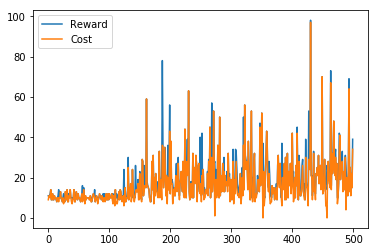

In [30]:
plt.plot(Rs, label = 'Reward')
plt.plot(Cs, label = 'Cost')
plt.legend()
plt.show()

In [31]:
len(observations)

14341

In [44]:
### TODO: reimplement w/o inner optimization, otherwise too slow.
def solve_CPO(S, A, R, C, delta = 0.1, d = 10, H_lambda = 0.01):
    # CPO hyperparameters

    # D_KL maximal distance
    #delta

    # maximal constraint return
    #d

    # matrix conditioner
    #H_lambda
    
    # calculating H, g, b, J from obtained data
    J_c_ = discount(C)[0]
    H_, b_, g_ = sess.run([H, b, g], feed_dict = {states: S, actions: A,
                                                  disc_rewards: discount(R), disc_costs: discount(C)})
    
    #plt.hist(np.abs(np.linalg.eig(H_)[0]))
    #plt.show()
    
    # converting to matrix form
    g_ = np.array([g_]).T
    b_ = np.array([b_]).T
    H_ = np.array(H_) + np.eye(len(H_)) * H_lambda

    # constraint dissatisfaction
    c = J_c_ - d

    # current parameters
    theta_k = list(iterate_flatten(sess.run(params)))
    
    # https://www.cvxpy.org/

    # Construct the problem.
    theta = cp.Variable(72)
    objective = cp.Maximize(g_.T @ (theta - theta_k))
    constraints = [c + b_.T @ (theta - theta_k) <= 0, cp.quad_form(theta - theta_k, H_) <= 2 * delta]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve(gp=False)
    # The optimal value for x is stored in `x.value`.
    #print(theta.value)
    # The optimal Lagrange multiplier for a constraint is stored in
    # `constraint.dual_value`.
    #print(constraints[0].dual_value, constraints[1].dual_value)
    
    if theta.value is None:
        print('Optimization failed: current policy nonsafe. Falling back to a safe solution...')
        
        # θ∗ = θk −sqrt(2δ/b^T H−1b)H^-1b. (eq 14)
        Hinv = np.linalg.inv(H_)
        theta_safe = theta_k - ((2 * delta / (b_.T @ Hinv @ b_)) ** 0.5 * Hinv @ b_).reshape(-1)
        load_params(params, theta_safe)
        return
    
    load_params(params, theta.value)

In [45]:
def load_params(params, vector):
    """ Params: list of tensors, vector: array with new values (shape as flattened params) """
    # index to start
    idx = 0
    
    # array with assign operators
    assigns = []
    
    # loop over parameters
    for p in params:
        # length of current parameter (flattened)
        curr_len = np.prod(p.shape)
        
        # new values for p
        p_new_value = vector[idx:idx+curr_len]
        
        # reshaping the values
        assigns.append(tf.assign(p, p_new_value.reshape(p.shape)))
        
        # incrementing start ID
        idx += curr_len
        
    # all assigns in one operation
    assigns = tf.group(assigns)
    
    # running the operation
    sess.run(assigns)

In [51]:
Rs = []
Cs = []
for _ in tqdm(range(10)):
    S, A, R, C = zip(*get_rollout())
    Cs.append(np.sum(C))
    Rs.append(np.sum(R))
    #print(np.sum(R), np.sum(C))
    solve_CPO(S, A, R, C, delta = 0.001, d = 10, H_lambda = 0.0001)

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


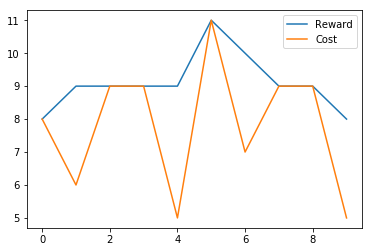

In [52]:
plt.plot(Rs, label = 'Reward')
plt.plot(Cs, label = 'Cost')
plt.legend()
plt.show()

In [88]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [47]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [23]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
